# TP6 - Clustering : Recommandations de livres

Dans cette séance on s'intéresse au dataset issue de [wonderbk.com](wonderbk.com) un site de vente de livre en ligne. Nous allons réaliser des clusters de livre pour constuire un système de recommandation de livre.
Les informations dont on dispose sont :
* **Title** : titre du livre
* **Authors** : Auteur du livre
* **Description** : Description du livre
* **Category** : Catégorie ou genre du livre
* **Publisher** : Maison d'édition du livre
* **Price Starting With ($)** : Prix initial du livre
* **Publish Date** : Date de la publication du livre

Commençons par importer les données.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("BooksDataset.csv")
df.head()

,Title,Authors,Description,Category,Publisher,Publish Date,Price
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,"Friday, January 1, 1993",Price Starting at $8.79
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,"Sunday, March 1, 1981",Price Starting at $4.99
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,"Thursday, September 1, 1983",Price Starting at $4.99
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,"Monday, April 1, 1991",Price Starting at $4.99
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,"Saturday, February 1, 1997",Price Starting at $5.32


## Nettoyage

On note que le dataset n'est pas exploitable en l'état, nous allons devoir faire un travail de mise en qualité avant de pouvoir construire le système de recommandation. Commençons par la colonne *Price*.

**Consigne** : Nettoyer la colonne *Price* pour la rendre numérique.

In [2]:
def clean_price_column(price):
    price = price.replace("Price Starting at $", "")
    price = price.replace(",", "")
    return float(price)

df["Price"] = df["Price"].apply(lambda price: clean_price_column(price))

**Consigne** : Constuire la colonne *Publish Year* qui correspond à l'année de publication.

In [3]:
df["Publish Year"] = df["Publish Date"].apply(lambda date: int(date[-4:]))

**Consigne** : Afficher la répartition du nombre de livre publié par an.

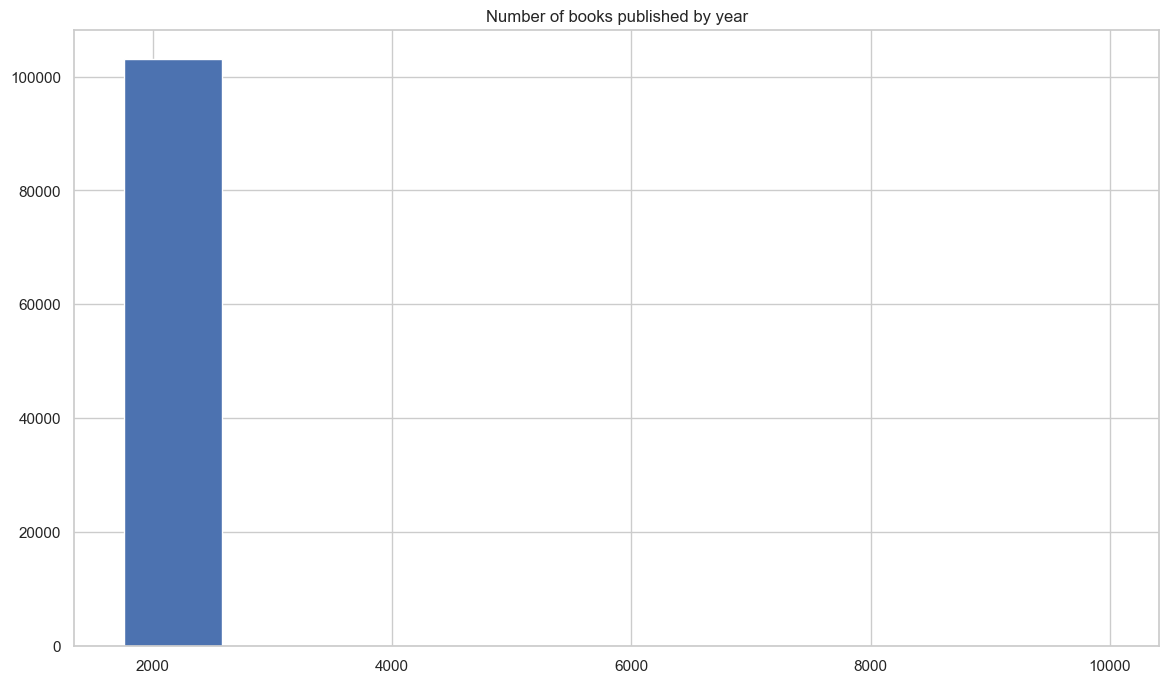

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
plt.hist(df["Publish Year"])
plt.title("Number of books published by year")
plt.show()

**Consigne** : Ne sélectionner que les livres publiés entre 1950 et 2024.

In [5]:
n_before = df.shape[0]
df = df.loc[(df["Publish Year"] > 1950) & (df["Publish Year"] < 2024), ]
n_after = df.shape[0]

print(f"Taille avant suppression: {n_before}, et après : {n_after}")

Taille avant suppression: 103082, et après : 102046


Il semblerait que la colonne *Authors* commence systématiquement par *By_*. 

**Consigne** : Vérifier si c'est effectivement le cas, et nettoyer la colonne en conséquence.

In [6]:
def clean_authors(authors):
    if authors[:3] != "By ":
        return np.nan
    else:
        return authors.replace("By ", "")

df["Authors"] = df["Authors"].apply(lambda authors: clean_authors(authors))

On s'intéresse avant de continuer aux valeurs manquantes. Pour construire notre système de recommandation, on souhaite en avoir aucune.

**Consigne** : Après avoir identifier avec la méthode [`isna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html) les colonnes contenant des valeurs manquantes, les supprimer avec la méthode [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html).


In [7]:
print("Valeurs manquantes :")
print(np.sum(df.isna(), axis=0))

n_before = df.shape[0]
df = df.dropna(ignore_index=True)
n_after = df.shape[0]

print(f"Taille avant suppression: {n_before}, et après : {n_after}")

Valeurs manquantes :
Title               0
Authors          1026
Description     31967
Category        25330
Publisher           8
Publish Date        0
Price               0
Publish Year        0
dtype: int64
Taille avant suppression: 102046, et après : 65096


On souhaite pouvoir exploiter la colonne *Category*. Pour le faire, nous allons faire un one hot encoding, mais nous devons le faire sur chaque categorie. Commençons par calculer la fréquence d'apparition de chaque catégorie.

In [8]:
categories = {}

for row in range(n_after):
    if type(df["Category"][row]) != str:
        continue
    for category in df["Category"][row].split(" , "):
        category = category.strip()
        if category in categories.keys():
            categories[category] += 1
        else:
            categories[category] = 1

categories = dict(sorted(categories.items(), key=lambda x: x[1], reverse=True))
print(categories)


{'General': 25637, 'Fiction': 17715, 'Juvenile Fiction': 6406, 'Religion': 3629, 'Romance': 3491, 'Cooking': 2858, 'Juvenile Nonfiction': 2658, 'History': 2580, 'Business & Economics': 2541, 'Historical': 2355, 'Thrillers': 2298, 'Biography & Autobiography': 2286, 'Mystery & Detective': 2273, 'Political Science': 1848, 'Literary': 1762, 'Reference': 1747, 'Health & Fitness': 1585, 'Young Adult Fiction': 1543, 'Social Science': 1511, 'United States': 1436, 'Suspense': 1318, 'Family & Relationships': 1279, 'Sports & Recreation': 1261, 'Travel': 1185, 'Contemporary': 1144, 'Self-help': 1084, 'Humor': 1037, 'Fantasy': 990, 'Science Fiction': 924, 'Readers': 891, 'Science': 850, 'Animals': 846, 'Social Themes': 843, 'Computers': 836, 'House & Home': 800, 'Psychology': 792, 'Crafts & Hobbies': 692, 'Parenting': 656, 'Pets': 633, 'Religious': 632, 'Christian Life': 624, 'Medical': 591, 'Gardening': 582, 'Christian': 550, 'Education': 538, 'Art': 531, 'Military': 523, 'Beginner': 517, 'Family'

**Consigne** : Sélectionner les 20 premiers types les plus fréquent, puis créer autant de colonne valant 1 si le livre correspond à la catégorie, 0 sinon.

In [9]:
top_categories = list(categories.keys())[:20]

for category in top_categories:
    df["Category_" + category] = df["Category"].apply(lambda categories: int(category in categories) if type(categories) == str else 0)


## Exploitation des descriptions

Beaucoup d'informations sont comprises dans ces lignes, et nous devons être capable de le transformer en nombre. Commençons par de l'analyse de sentiments. Il existe plusieurs librairies permettant de faire cela, la première est [TextBlob](https://textblob.readthedocs.io/en/dev/) :

In [10]:
from textblob import TextBlob

texts = ["Theo always give great lecture", "Theo is reallty not a good lecturer", "Theo is OK at his job"]
for text in texts:
    blob = TextBlob(text)
    print(f"Analyse de \"{text}\" : {blob.sentiment}")

Analyse de "Theo always give great lecture" : Sentiment(polarity=0.8, subjectivity=0.75)
Analyse de "Theo is reallty not a good lecturer" : Sentiment(polarity=-0.35, subjectivity=0.6000000000000001)
Analyse de "Theo is OK at his job" : Sentiment(polarity=0.5, subjectivity=0.5)


Une autre est [VADER](https://vadersentiment.readthedocs.io/en/latest/) :

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
for text in texts:
    scores = analyzer.polarity_scores(text)
    print(f"Analyse de \"{text}\" : {scores}")

Analyse de "Theo always give great lecture" : {'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'compound': 0.6249}
Analyse de "Theo is reallty not a good lecturer" : {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.3412}
Analyse de "Theo is OK at his job" : {'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compound': 0.4466}


On souhaite intégrer ces informations dans notre datasets.

**Consigne** : Créer une colonne *Description_sentiment_Blob* qui correspond à la valeur *polarity* calculée par TextBlob et une autre colonne *Description_sentiment_VADER* qui correspond à la valeur *compound* calculée par VADER. Faire de même avec la colonne *Title*.

In [12]:
vader_analyzer = SentimentIntensityAnalyzer()
for column in ["Title", "Description"]:
    df[column + "_sentiment_Blob"] = df[column].apply(lambda string: TextBlob(string).sentiment.polarity)
    df[column + "_sentiment_VADER"] = df[column].apply(lambda string: analyzer.polarity_scores(string)["compound"])

On souhaite étudier la distribution et la corrélation entre les scores, pour le titre et la description des livres.

**Consigne** : Afficher sur un même graphique la distribution des scores pour la description entre TextBlob et VADER.

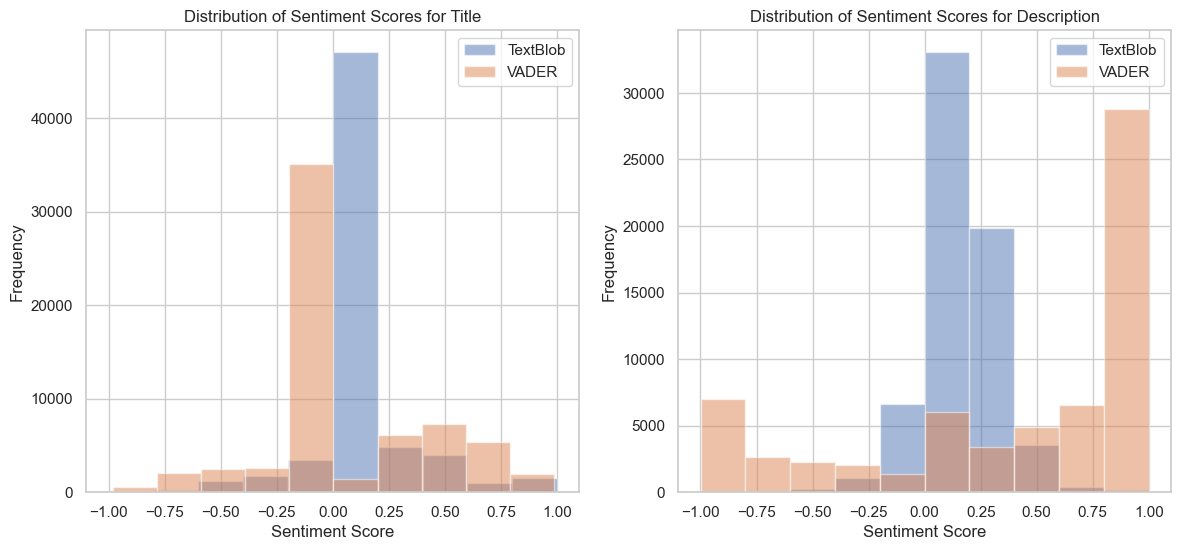

In [13]:
plt.figure(figsize=(14, 6))

for index, column in enumerate(["Title", "Description"]):
    plt.subplot(1, 2, index+1)
    plt.hist(df[column + "_sentiment_Blob"], bins=10, alpha=0.5, label='TextBlob')
    plt.hist(df[column + "_sentiment_VADER"], bins=10, alpha=0.5, label='VADER')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentiment Scores for ' + column)
    plt.legend()


**Consigne** : Afficher un scatter plot entre les score de TextBlob et de VADER pour les deux colonnes concernées.

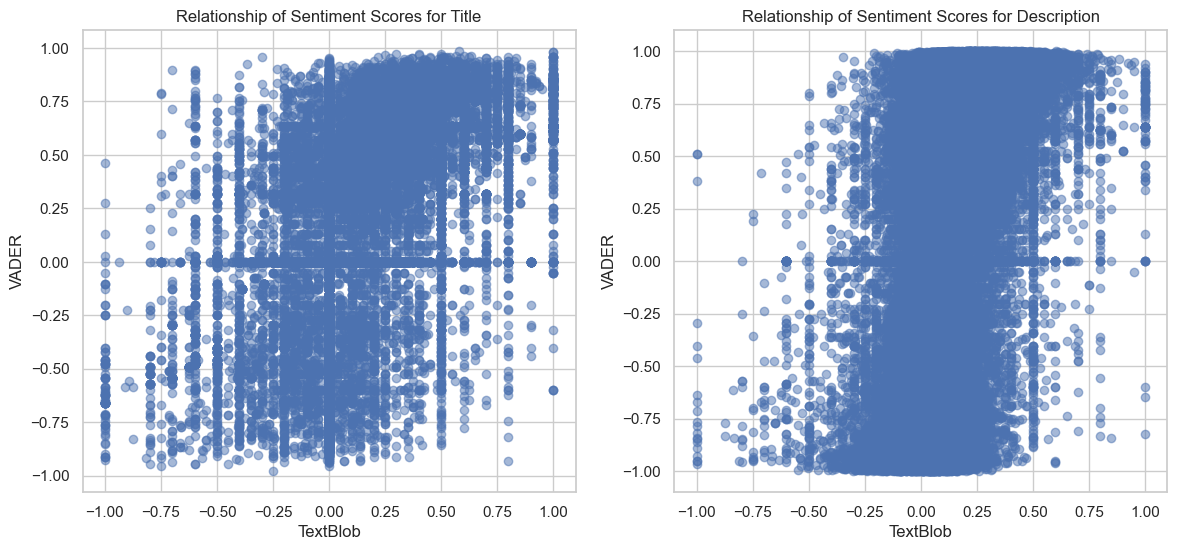

In [14]:
plt.figure(figsize=(14, 6))

for index, column in enumerate(["Title", "Description"]):
    plt.subplot(1, 2, index+1)
    plt.scatter(df[column + "_sentiment_Blob"], df[column + "_sentiment_VADER"], alpha=0.5)
    plt.xlabel('TextBlob')
    plt.ylabel('VADER')
    plt.title('Relationship of Sentiment Scores for ' + column)

plt.show()

## Calcul des clusters

Nous avons maintenant accès à un dataset permettant d'exploiter du Machine Learning non supervisé. Puisque les résolutions des problèmes que les algorithmes vont résoudre peuvent exploiter des variantes d'une descente de gradient, nous devons préparer en conséquence la matrice.

**Consigne** : A partir du dataset *df*, ne conserver que les colonnes numériques puis avec la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) standardiser les données.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.drop(columns=["Title", "Authors", "Description", "Publisher", "Category", "Publish Date"], axis=1)
X = scaler.fit_transform(X)

**Consigne** : A l'aide de la classe [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) calculer les clusters et les stocker dans une variable *labels*. On prendra *n_clusters=5*. Finalement, afficher le nombre d'observations dans chaque cluster.

In [16]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5)
labels = model.fit_predict(X)
distributions = [{"cluster": cluster, "observations": np.sum(labels == cluster)} for cluster in set(labels)]
print(distributions)

[{'cluster': 0, 'observations': 2164}, {'cluster': 1, 'observations': 50810}, {'cluster': 2, 'observations': 3636}, {'cluster': 3, 'observations': 6200}, {'cluster': 4, 'observations': 2286}]


**Consigne** : Calculer la performance du clustering avec la fonction [`silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [17]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels)
print(f"Silhouette score: {score:.4f}")

Silhouette score: 0.0924


On souhaite a présent avoir un peu d'explicabilité pour ces clusters. Pour le faire, nous allons reporter les labels appris dans le dataset initial.

**Consigne** : Construire un dataset *data* à partir de *df*, et y ajouter le vecteur *labels*. On supprimera des catégories OHE pour la lisibilité.

In [18]:
data = df.copy()
data["labels"] = labels

data = data[[column for column in data.columns if column[:9] != "Category_"]]
data.head()

,Title,Authors,Description,Category,Publisher,Publish Date,Price,Publish Year,Title_sentiment_Blob,Title_sentiment_VADER,Description_sentiment_Blob,Description_sentiment_VADER,labels
0,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,"Poetry , General",VSP Books,"Saturday, September 1, 2001",19.96,2001,0.0,0.0000,0.000000,0.8176,1
1,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,"Biography & Autobiography , General",Random House,"Monday, June 1, 1987",4.99,1987,0.0,-0.4404,0.020000,0.8126,4
2,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",Workman Publishing Company,"Sunday, January 1, 1978",4.99,1978,0.0,-0.3182,0.186147,0.8020,1
3,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",Simon & Schuster,"Monday, October 1, 2001",4.99,2001,-0.4,-0.7783,-0.043766,-0.9975,1
4,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography , General",Harper Perennial,"Friday, May 1, 1998",5.29,1998,0.7,0.7964,0.134722,-0.2732,2


**Consigne** : Explorer un des clusters et essayer de comprendre la constitution du cluster. On pourra utiliser la méthode `describe` pour les données numériques.

Testons à présent l'algorithme DBSCAN. Nous n'avons pas cette fois à spécifier le nombre de cluster que l'on souhaite obtenir. Nous devons donc commencer par identifier les informations que l'on souhaite avoir.

**Consigne** : Définir une fonction `explore_clusters` qui prend en paramètre la matrice $X$ et les labels calculés. Elle affichera :
* Le silhouette score
* Le nombre de cluster
* La répartition des observations dans les clusters

In [19]:
def explore_clusters(X, labels):
    n_clusters = len(set(labels))
    score = silhouette_score(X, labels)
    distributions = [{"cluster": cluster, "observations": np.sum(labels == cluster)} for cluster in set(labels)]
    print(f"Silhouette score: {score:.4f}\nCluster: {n_clusters}\n{distributions}")

**Consigne**: Entraîner avec les valeurs par défaut l'algorithme [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) puis utiliser la fonction `explore_clusters`.

In [20]:
from sklearn.cluster import DBSCAN

model = DBSCAN()
labels = model.fit_predict(X)
explore_clusters(X, labels)

Silhouette score: -0.4194
Cluster: 405
[{'cluster': 0, 'observations': 647}, {'cluster': 1, 'observations': 15}, {'cluster': 2, 'observations': 2120}, {'cluster': 3, 'observations': 245}, {'cluster': 4, 'observations': 12}, {'cluster': 5, 'observations': 6}, {'cluster': 6, 'observations': 4010}, {'cluster': 7, 'observations': 517}, {'cluster': 8, 'observations': 2235}, {'cluster': 9, 'observations': 7170}, {'cluster': 10, 'observations': 472}, {'cluster': 11, 'observations': 241}, {'cluster': 12, 'observations': 465}, {'cluster': 13, 'observations': 1019}, {'cluster': 14, 'observations': 232}, {'cluster': 15, 'observations': 580}, {'cluster': 16, 'observations': 146}, {'cluster': 17, 'observations': 129}, {'cluster': 18, 'observations': 574}, {'cluster': 19, 'observations': 285}, {'cluster': 20, 'observations': 547}, {'cluster': 21, 'observations': 6}, {'cluster': 22, 'observations': 188}, {'cluster': 23, 'observations': 938}, {'cluster': 24, 'observations': 2918}, {'cluster': 25, 'obs

**Consigne**: A l'aide du cours et par tatônnement entraîner DBSCAN avec d'autres paramètrages.